# NBA Data Analysis 3 :: Win Classification Models

###### Abhishek Menothu, Johnathen Wigfall, Scott Campbell, Trevor Rowland

## Executive Summary, Business Context

This notebook aims to create classification models to predict wins in NBA games given summary statistics of a game. Using these models, coaches, teams, and organizations can examine the predictor variables with high predictive weight in classifying a win or loss, and can focus on improving those statistics to drive more wins.

**GO BACK AND MODIFY WITH INSIGHTS, THIS SHOULD EXPLAIN THE PRESENTATION WITHOUT HAVING TO SCROLL FURTHER**

## Data Overview

The data used is NBA Box Scores collected from 2004-2024, and filtered down to 2013-2024. This filtering was done due to weaker data in the older seasons and poor data collection from the NBA. The data is accessed from a google drive folder, and can be seen below.

**ADD A SUMMARY HERE. WE...**
- Drop NA Data
- Remove ID Values
- Remove Postgame Totals with high predictive power

In [1]:
# Import Packages
import pandas as pd
import numpy as np

# Collect Data from Google Drive
gdrive_url = 'https://drive.google.com/file/d/1U2UaHWRSkUXfJBn4kBHPYttd3dvw_CZF/view?usp=drive_link'
file_id = '1U2UaHWRSkUXfJBn4kBHPYttd3dvw_CZF'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url, encoding='utf-8')

# Filter Data to 2013-2024
df = df[df['season'].str[:4].astype(int) > 2012] # Remove old seasons (only keeping seasons 2013-14 onward)
#df = df.loc[(df['distance'] != 0 ) & (df['touches'] != 0)] # exclude rows where 0 in certain columns doesnt make sense
df = df.dropna() # drop rows with missing values 
df = df.reset_index(drop=True) # reset index
df.head()

,game_id,season,team_id,team_name,tri_code,team_slug,minutes,field_goals_made,field_goals_attempted,field_goals_percentage,...,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,is_home_team,won_game,is_playoff_game,is_regular_game
0,41300405,2013-14,1610612759,Spurs,SAS,spurs,240:00,37.0,78.0,0.474,...,0.475,0.474,15.0,24.0,0.625,87.0,1,1,1,0
1,41300404,2013-14,1610612748,Heat,MIA,heat,240:00,32.0,71.0,0.451,...,0.439,0.451,16.0,19.0,0.842,107.0,1,0,1,0
2,41300403,2013-14,1610612748,Heat,MIA,heat,240:00,32.0,62.0,0.516,...,0.516,0.516,14.0,20.0,0.700,111.0,1,0,1,0
3,41300402,2013-14,1610612759,Spurs,SAS,spurs,240:00,36.0,82.0,0.439,...,0.452,0.439,17.0,24.0,0.708,98.0,1,0,1,0
4,41300401,2013-14,1610612759,Spurs,SAS,spurs,240:00,40.0,68.0,0.588,...,0.472,0.588,12.0,21.0,0.571,95.0,1,1,1,0


### Cleaning Data

We can also drop ID variables like `game_id`, `team_id`, etc. Additionally, we will drop variables like `points`, `three_pointers_made`, or `plus_minus_points` that are rolling amounts during the game, but in our data are postgame totals, with extremely high predictive power. Because of this high predictive power, they must be removed to prevent overfitting.

In [2]:
try:
    drop_vars = [
        'game_id', 
        'team_id', 
        'team_name', 
        'tri_code', 
        'team_slug', 
        'season', # dropping for now but could technically be a cat dep var
        'minutes'] + ['points',
                       'opponent_points',
                        'plus_minus_points',
                        'field_goals_made',
                        'three_pointers_made',
                        'free_throws_made',
                        'contested_field_goals_made',
                        'uncontested_field_goals_made',
                        'defended_at_rim_field_goals_made',
                        'estimated_net_rating',
                        'net_rating',
                        'estimated_defensive_rating',
                        'defensive_rating',
                        'estimated_offensive_rating',
                        'offensive_rating',]
    df = df.drop(drop_vars, axis=1)
    df.head()
except Exception as e:
    print('drop_vars already dropped')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30060 entries, 0 to 30059
Data columns (total 50 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   field_goals_attempted                  30060 non-null  float64
 1   field_goals_percentage                 30060 non-null  float64
 2   three_pointers_attempted               30060 non-null  float64
 3   three_pointers_percentage              30060 non-null  float64
 4   free_throws_attempted                  30060 non-null  float64
 5   free_throws_percentage                 30060 non-null  float64
 6   rebounds_offensive                     30060 non-null  float64
 7   rebounds_defensive                     30060 non-null  float64
 8   rebounds_total                         30060 non-null  float64
 9   steals                                 30060 non-null  float64
 10  blocks                                 30060 non-null  float64
 11  tu

Lastly, we can drop `is_playoff_game`. This variable is redundant, as we already have a variable `is_regular_game` that, if 0, means the game is a playoff game.

In [3]:
df = df.drop(columns=['is_playoff_game'], axis=1)
cat_vars = ['is_home_team', 'won_game', 'is_regular_game']
df_cat = df[cat_vars]
df_num = df.drop(cat_vars, axis=1)

# assertion to ensure that split happened properly
assert df_cat.shape[1] + df_num.shape[1] == df.shape[1]

### Removing High Correlation and Near-Zero Variance

In [4]:
# From John's notebook
def removeHighCorr (data,thresh):
  from dython.nominal import associations
  corr_matrix=associations(dataset=data, compute_only=True)['corr'].abs()
  upper_tri=corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
  to_drop=[column for column in upper_tri.columns if any(upper_tri[column]>thresh)]
  new_data=data.drop(to_drop,axis=1)
  return new_data

In [5]:
pre = df_num.shape[1]
df_num_nhc = removeHighCorr(df_num, 0.7) # _nhc --> no high corr
post = len(df_num_nhc.columns.tolist())

print(f'pre: {pre} \n post: {post}')

pre: 46 
 post: 24


And now we remove NZV.

In [6]:
pre = post

from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold(threshold=0.1)
vt.fit_transform(df_num_nhc)

cols = df_num_nhc.columns[vt.get_support()]
post = len(cols)

df_num_nhc_nnzv = df_num_nhc[cols] # _nnzv --> no near zero variance

print(f'pre: {pre} \n post: {post}')

pre: 24 
 post: 15


And now we can take a look at the finished dataframe.

In [7]:
df_num_nhc_nnzv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30060 entries, 0 to 30059
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   field_goals_attempted      30060 non-null  float64
 1   three_pointers_attempted   30060 non-null  float64
 2   free_throws_attempted      30060 non-null  float64
 3   rebounds_offensive         30060 non-null  float64
 4   rebounds_defensive         30060 non-null  float64
 5   steals                     30060 non-null  float64
 6   blocks                     30060 non-null  float64
 7   turnovers                  30060 non-null  float64
 8   fouls_personal             30060 non-null  float64
 9   estimated_pace             30060 non-null  float64
 10  pace                       30060 non-null  float64
 11  distance                   30060 non-null  float64
 12  rebound_chances_offensive  30060 non-null  float64
 13  secondary_assists          30060 non-null  flo

Lastly, we can recombine the split categorical and numeric data into the final dataframe for the model.

In [8]:
df_full = pd.concat([df_num_nhc_nnzv.reset_index(drop=True), df_cat.reset_index(drop=True)], axis=1)

# checks to make sure merge happened properly since past experience as shown that incorrect merge will mess up the fitting

# assertion for row size (since feature elimination did not touch rows and only bad merge would mess it up)
assert df_full.shape[0] == df.shape[0] # df is right before split into _cat/_num 

# assertion for nulls (since nulls were cleaned out before feature elimination) 
assert df_full.isna().sum().sum() == 0

In [9]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30060 entries, 0 to 30059
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   field_goals_attempted      30060 non-null  float64
 1   three_pointers_attempted   30060 non-null  float64
 2   free_throws_attempted      30060 non-null  float64
 3   rebounds_offensive         30060 non-null  float64
 4   rebounds_defensive         30060 non-null  float64
 5   steals                     30060 non-null  float64
 6   blocks                     30060 non-null  float64
 7   turnovers                  30060 non-null  float64
 8   fouls_personal             30060 non-null  float64
 9   estimated_pace             30060 non-null  float64
 10  pace                       30060 non-null  float64
 11  distance                   30060 non-null  float64
 12  rebound_chances_offensive  30060 non-null  float64
 13  secondary_assists          30060 non-null  flo

In [10]:
# Check for Class Imbalance (We should see around a 50/50 split)
ct = pd.crosstab(index=df_full['won_game'], columns='count')
ct_norm = ct / ct.sum() # to show percentages
ct_norm

col_0,count
won_game,
0,0.5
1,0.5


## Model Building

Now that the data has been preprocessed, we can create the models for the analysis. We will be using the following models:

- Logistic Regression (LR)
- Decision Trees (DT)
- Random Forest (RF)
- Support Vector Machines (SVM)
- Adaptive Neural Networks (ANN)
- XGBoost (XGB)

### Methodology

The team created an 80/20 test-train split, and created the listed models with the training data. These models were then used to gather predictions of the testing data, and the predictions were compared against the observed dependent variable in the testing split. This gave us accuracy measures and ROC scores to compare the models and examine their effectiveness.

After running the models initially, features in the dataset had a feature importance of over 90%, leading to severe overfitting, and a feature audit had to be performed. The features removed were the raw and estimated offensive, defensive, and overall team ratings. Once these changes were made, the overfitting issue was resolved. The ROC, AUC, Accuracy, and Misclassification measures then provided the team with the following rankings for the models, based on their AUC.

- 1. SVM
- 2. Logistic Regression
- 3. ANN
- 4. XGBoost
- 5. RF
- 6. DT




### Test-Train Split

In [11]:
dep_var_name = 'won_game'

dep_var = df_full[dep_var_name]
ind_var = df_full.drop([dep_var_name], axis=1)

# data partitioning
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(ind_var, dep_var, test_size=0.2, random_state=42)

# # Perform Mean Encoding
# from feature_engine.encoding import MeanEncoder
# mean_enc = MeanEncoder().fit(train_X, train_y)

# mean_enc_train = mean_enc.transform(train_X)
# mean_enc_test = mean_enc.transform(test_X)

# Standardize Data for the Models
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(train_X)

std_train = pd.DataFrame(scaler.transform(train_X), columns=train_X.columns)
std_test = pd.DataFrame(scaler.transform(test_X), columns=test_X.columns)

In [12]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

### Logistic Regression Model

In [13]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(solver='liblinear', random_state=42).fit(train_X, train_y)

lr_class = lr_model.predict(test_X)
lr_acc = accuracy_score(test_y, lr_class)
lr_mis = 1 - lr_acc

### Decision Tree Model

In [14]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(random_state=42, max_depth=3).fit(std_train, train_y)
dt_class = dt_model.predict(std_test)
dt_acc = accuracy_score(test_y, dt_class)
dt_mis = 1 - dt_acc

### Random Forest Model

In [15]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42, max_depth=3).fit(std_train, train_y)

rf_class = rf_model.predict(std_test)
rf_acc = accuracy_score(test_y, rf_class)
rf_mis = 1 - rf_acc

### SVM Model

In [16]:
from sklearn.svm import SVC
svm_model = SVC(random_state=50).fit(std_train, train_y)

svm_class = svm_model.predict(std_test)
svm_acc = accuracy_score(test_y, svm_class)
svm_mis = 1 - svm_acc

### ANN Model

In [17]:
from sklearn.neural_network import MLPClassifier
ann_model = MLPClassifier(hidden_layer_sizes=3,
                    random_state=50,
                    activation='logistic',
                    solver='sgd',
                    max_iter=400).fit(std_train, train_y)

ann_class = ann_model.predict(std_test)
ann_acc = accuracy_score(test_y, ann_class)
ann_mis = 1 - ann_acc

### XGBoost Model

In [18]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(eval_metric='logloss',
                          n_estimators=5, 
                          max_depth=5, 
                          learning_rate=.1).fit(std_train, train_y)

xgb_class = xgb_model.predict(std_test)
xgb_acc = accuracy_score(test_y, xgb_class)
xgb_mis = 1 - xgb_acc

## Model Evaluation

### Accuracy and Misclassification Table



In [19]:
data = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM', 'ANN', 'XGBoost'],
    'Accuracy': [lr_acc, dt_acc, rf_acc, svm_acc, ann_acc, xgb_acc],
    'Misclassification Rate': [lr_mis, dt_mis, rf_mis, svm_mis, ann_mis, xgb_mis]
}

df_acc_mis = pd.DataFrame(data)
df_acc_mis


,Model,Accuracy,Misclassification Rate
0,Logistic Regression,0.741351,0.258649
1,Decision Tree,0.654857,0.345143
2,Random Forest,0.685130,0.314870
3,SVM,0.744844,0.255156
4,ANN,0.737359,0.262641
5,XGBoost,0.694444,0.305556


### ROC Curves and AUC Score

In [20]:
lr_auc = roc_auc_score(test_y, lr_class)
dt_auc = roc_auc_score(test_y, dt_class)
rf_auc = roc_auc_score(test_y, rf_class)
svm_auc = roc_auc_score(test_y, svm_class)
ann_auc = roc_auc_score(test_y, ann_class)
xgb_auc = roc_auc_score(test_y, xgb_class)

lr_fpr, lr_tpr, _ = roc_curve(test_y, lr_class)
dt_fpr, dt_tpr, _ = roc_curve(test_y, dt_class)
rf_fpr, rf_tpr, _ = roc_curve(test_y, rf_class)
svm_fpr, svm_tpr, _ = roc_curve(test_y, svm_class)
ann_fpr, ann_tpr, _ = roc_curve(test_y, ann_class)
xgb_fpr, xgb_tpr, _ = roc_curve(test_y, xgb_class)

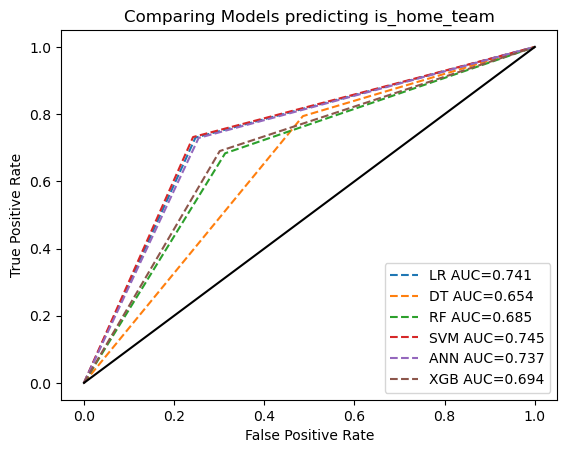

In [21]:
import matplotlib.pyplot as plt

plt.plot(lr_fpr, lr_tpr, linestyle='--', label='{}{:.3f}'.format("LR AUC=", lr_auc))
plt.plot(dt_fpr, dt_tpr, linestyle='--', label='{}{:.3f}'.format("DT AUC=", dt_auc))
plt.plot(rf_fpr, rf_tpr, linestyle='--', label='{}{:.3f}'.format("RF AUC=", rf_auc))
plt.plot(svm_fpr, svm_tpr, linestyle='--', label='{}{:.3f}'.format("SVM AUC=", svm_auc))
plt.plot(ann_fpr, ann_tpr, linestyle='--', label='{}{:.3f}'.format("ANN AUC=", ann_auc))
plt.plot(xgb_fpr, xgb_tpr, linestyle='--', label='{}{:.3f}'.format("XGB AUC=", xgb_auc))
plt.plot([0,1], [0,1], linestyle='solid', c='k')


plt.title('Comparing Models predicting is_home_team')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## Examining Feature Importance

~~We are currently getting around 96% accuracy for all models, indicating extreme overfitting. We need to examine the feature importance of the training data to make sure each feature is relatively predictive, without an extreme outlier.~~

Now the models are returning closer to 75%, which aligns with usual accuracy metrics for win classification models and doesn't seem to indicate overfitting. Additionally, features only have a maximum predictive weight of around 50%, much lower than the initial 90+% we were seeing before.

### LR Coefficients (Log Odds Interpretation)

First lets grab the coefficients and relevant feature names into a df to examine

In [28]:
coeffs = lr_model.coef_[0]
feature_names = train_X.columns

log_df = pd.DataFrame({'Feature': feature_names, 'Coeff':coeffs})
# manually inspect sorted log_df and manually inspect for top and bottom N rows (highest magnitude = strongest) 
print(log_df.sort_values(by='Coeff', ascending=True).head(3))
print()
print(log_df.sort_values(by='Coeff', ascending=True).tail(3))

                  Feature     Coeff
7               turnovers -0.203541
10                   pace -0.143877
0   field_goals_attempted -0.113085

               Feature     Coeff
4   rebounds_defensive  0.248570
5               steals  0.265705
15        is_home_team  0.441072


In [29]:
log_df.sort_values(by='Coeff', ascending=True)

,Feature,Coeff
7,turnovers,-0.203541
10,pace,-0.143877
0,field_goals_attempted,-0.113085
14,free_throw_assists,-0.083757
12,rebound_chances_offensive,-0.056378
8,fouls_personal,-0.013900
1,three_pointers_attempted,-0.002469
2,free_throws_attempted,0.015567
11,distance,0.040554
6,blocks,0.074441


We've manually identified the strongest features (3 highest and 3 lowest coeff values)

In [30]:
from math import exp

strongest_features  = ['turnovers', 'pace', 'field_goals_attempted', 'rebounds_defensive', 'steals', 'is_home_team']

for idx in range(log_df.shape[0]):
    coeff = log_df['Coeff'].tolist()[idx]
    feature = log_df['Feature'].tolist()[idx]
    
    if feature in strongest_features:
    
        factor = exp(coeff)
        if factor > 1: 
            print(f'For each additional {feature} the odds of winning an NBA game INCREASE by a factor of {factor}\n')
        
        elif factor < 1:
            print(f'For each additional {feature} the odds of winning an NBA game DECREASE by a factor of {factor}\n')

For each additional field_goals_attempted the odds of winning an NBA game DECREASE by a factor of 0.8930750064974812

For each additional rebounds_defensive the odds of winning an NBA game INCREASE by a factor of 1.2821910608243325

For each additional steals the odds of winning an NBA game INCREASE by a factor of 1.3043506376875598

For each additional turnovers the odds of winning an NBA game DECREASE by a factor of 0.8158369254368842

For each additional pace the odds of winning an NBA game DECREASE by a factor of 0.8659945547754891

For each additional is_home_team the odds of winning an NBA game INCREASE by a factor of 1.5543731722298455



For that last binary case, add at the end saying 'compared to having an away game' (since thats what 0 for that var means)

## Insightful summary statistics

### turnover impact on won_game

In [31]:
df_test1 = df_full.copy()

# Analyze impact of turnovers on win probability
turnover_bins = np.quantile(df_test1['turnovers'], [0, 0.25, 0.5, 0.75, 1])
df_test1['turnover_group'] = pd.cut(df_test1['turnovers'], bins=turnover_bins)

turnover_stats = df_test1.groupby('turnover_group')['won_game'].agg(['mean', 'count'])
turnover_stats.columns = ['Win %', 'Number of Games']
print("Win % by Turnover Group:")
print(turnover_stats)

Win % by Turnover Group:
                   Win %  Number of Games
turnover_group                           
(1.0, 11.0]     0.561647             9303
(11.0, 13.0]    0.511992             5879
(13.0, 16.0]    0.484103             8052
(16.0, 33.0]    0.424238             6824


C:\Users\abhi-\AppData\Local\Temp\ipykernel_31348\1448637694.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  turnover_stats = df_test1.groupby('turnover_group')['won_game'].agg(['mean', 'count'])


### steal impact on won_game

In [32]:
df_test2 = df_full.copy()

steals_bins = np.quantile(df_test2['steals'], [0, 0.25, 0.5, 0.75, 1])
df_test2['steals_group'] = pd.cut(df_test2['steals'], bins=steals_bins)

steals_stats = df_test2.groupby('steals_group')['won_game'].agg(['mean', 'count'])
steals_stats.columns = ['Win %', 'Number of Games']
print('Win % by Steal Group')
print(steals_stats)

Win % by Steal Group
                 Win %  Number of Games
steals_group                           
(0.0, 6.0]    0.431855            11050
(6.0, 7.0]    0.492126             4064
(7.0, 10.0]   0.530945             9937
(10.0, 22.0]  0.596509             4984


C:\Users\abhi-\AppData\Local\Temp\ipykernel_31348\3359310941.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  steals_stats = df_test2.groupby('steals_group')['won_game'].agg(['mean', 'count'])


### rebound defensive impact on won_game

In [33]:
df_test3 = df_full.copy()

rebounds_defensive_bins = np.quantile(df_test3['rebounds_defensive'], [0, 0.25, 0.5, 0.75, 1])
df_test3['rebounds_defensive_group'] = pd.cut(df_test3['rebounds_defensive'], bins=rebounds_defensive_bins)

rebounds_defensive_stats = df_test3.groupby('rebounds_defensive_group')['won_game'].agg(['mean', 'count'])
rebounds_defensive_stats.columns = ['Win %', 'Number of Games']
print('Win % by Rebounds Defensive Group')
print(rebounds_defensive_stats)

Win % by Rebounds Defensive Group
                             Win %  Number of Games
rebounds_defensive_group                           
(1.0, 30.0]               0.287094             8903
(30.0, 33.0]              0.437281             6282
(33.0, 37.0]              0.578094             7952
(37.0, 60.0]              0.741115             6922


C:\Users\abhi-\AppData\Local\Temp\ipykernel_31348\1682830906.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rebounds_defensive_stats = df_test3.groupby('rebounds_defensive_group')['won_game'].agg(['mean', 'count'])


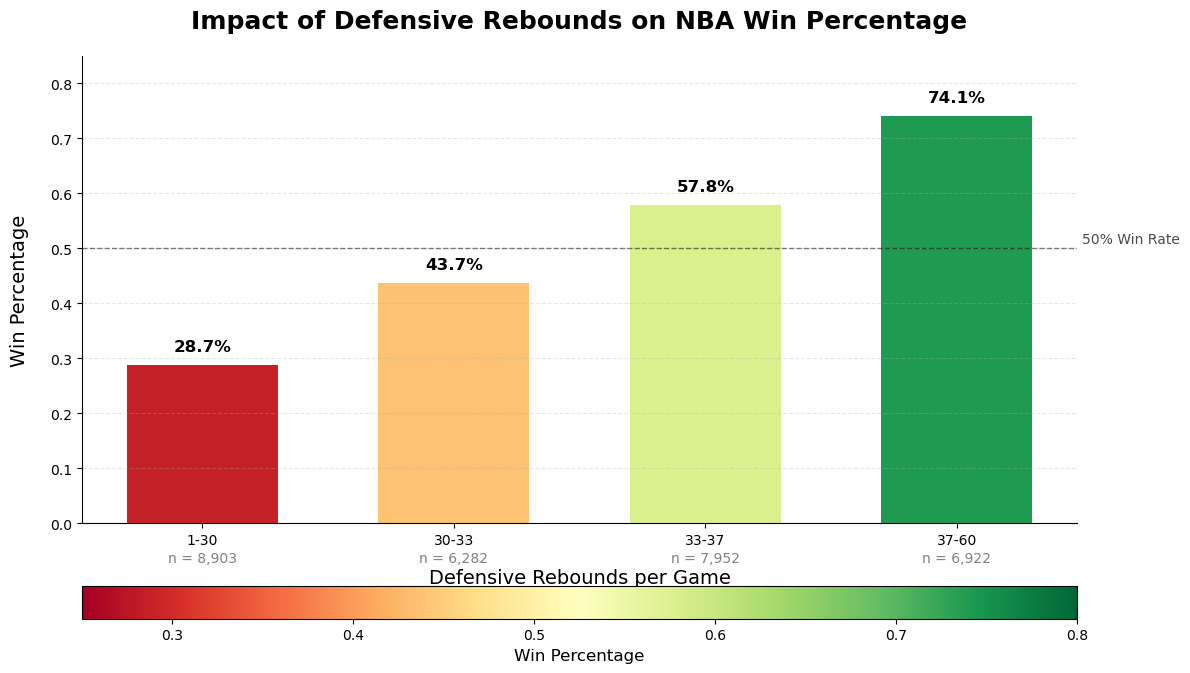

In [44]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Setup the data
rebound_groups = ['1-30', '30-33', '33-37', '37-60']
win_percentages = [0.287094, 0.437281, 0.578094, 0.741115]
game_counts = [8903, 6282, 7952, 6922]

# Create a colormap to represent win percentages
cmap = plt.cm.RdYlGn  # Red -> Yellow -> Green
norm = mcolors.Normalize(vmin=0.25, vmax=0.8)  # Set range for color mapping

fig, ax = plt.subplots(figsize=(12, 7))

# Plot with gradient colors
bars = ax.bar(rebound_groups, win_percentages, 
              color=[cmap(norm(pct)) for pct in win_percentages],
              width=0.6)

# Add win percentage labels on top of bars
for bar, pct in zip(bars, win_percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.02,
            f'{pct:.1%}', ha='center', va='bottom', fontsize=12, fontweight='bold',
            color='black')

# Add game count labels below x-axis
for i, count in enumerate(game_counts):
    ax.text(i, -0.05, f'n = {count:,}', ha='center', va='top', fontsize=10,
            color='gray')

# Add a reference line and text for 50% win rate
ax.axhline(y=0.5, color='black', linestyle='--', alpha=0.5, linewidth=1)
ax.text(3.5, 0.51, '50% Win Rate', fontsize=10, color='black', alpha=0.7)

# Set labels and title
ax.set_xlabel('Defensive Rebounds per Game', fontsize=14, labelpad=15)
ax.set_ylabel('Win Percentage', fontsize=14, labelpad=15)
ax.set_title('Impact of Defensive Rebounds on NBA Win Percentage', 
             fontsize=18, pad=20, fontweight='bold')

# Styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0, 0.85)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add a colorbar legend
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', pad=0.1, aspect=30)
cbar.set_label('Win Percentage', fontsize=12)

plt.tight_layout()

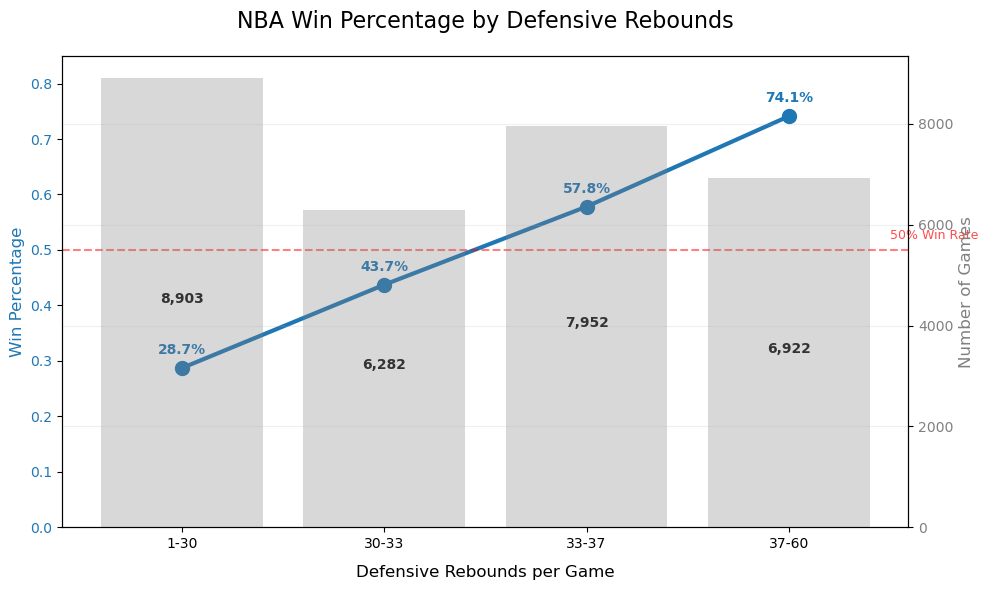

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Setup the data
rebound_groups = ['1-30', '30-33', '33-37', '37-60']
win_percentages = [0.287094, 0.437281, 0.578094, 0.741115]
game_counts = [8903, 6282, 7952, 6922]

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plot win percentage as a line with points
line = ax1.plot(rebound_groups, win_percentages, 'o-', color='#1f77b4', linewidth=3, markersize=10)
ax1.set_ylabel('Win Percentage', color='#1f77b4', fontsize=12)
ax1.tick_params(axis='y', labelcolor='#1f77b4')
ax1.set_ylim(0, 0.85)

# Add win percentage labels
for i, pct in enumerate(win_percentages):
    ax1.annotate(f"{pct:.1%}", 
                xy=(i, pct),
                xytext=(0, 10),
                textcoords="offset points",
                ha='center', 
                fontweight='bold',
                color='#1f77b4')

# Plot game counts as bars
bars = ax2.bar(rebound_groups, game_counts, alpha=0.3, color='gray')
ax2.set_ylabel('Number of Games', color='gray', fontsize=12)
ax2.tick_params(axis='y', labelcolor='gray')

# Add game count labels inside bars
for bar, count in zip(bars, game_counts):
    ax2.annotate(f"{count:,}", 
                xy=(bar.get_x() + bar.get_width()/2, count/2),
                ha='center', 
                color='#333333',
                fontweight='bold')

# Add a reference line at 50% win rate
ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
ax1.text(3.5, 0.52, '50% Win Rate', fontsize=9, color='red', alpha=0.7)

# Title and labels
plt.title('NBA Win Percentage by Defensive Rebounds', fontsize=16, pad=20)
ax1.set_xlabel('Defensive Rebounds per Game', fontsize=12, labelpad=10)
plt.grid(axis='y', alpha=0.2)

plt.tight_layout()

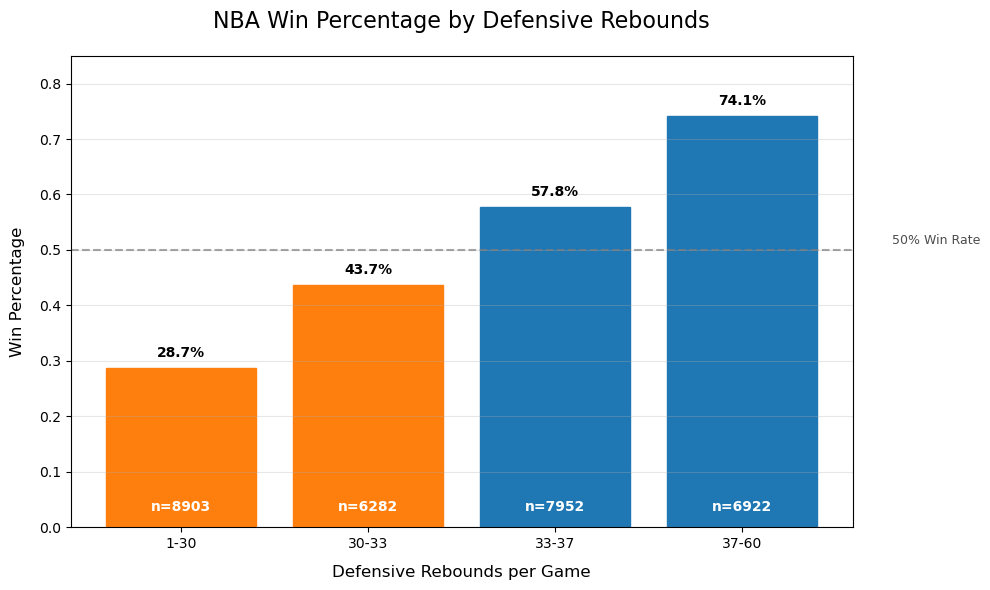

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Create labels for the rebound groups that are easier to read
rebound_groups = ['1-30', '30-33', '33-37', '37-60']
win_percentages = [0.287094, 0.437281, 0.578094, 0.741115]
game_counts = [8903, 6282, 7952, 6922]

plt.figure(figsize=(10, 6))
bars = plt.bar(rebound_groups, win_percentages, color=sns.color_palette("Blues", 4))

# Add data labels on top of each bar
for bar, win_pct in zip(bars, win_percentages):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f"{win_pct:.1%}", ha='center', fontweight='bold')

# Add game counts at the bottom of each bar
for bar, count in zip(bars, game_counts):
    plt.text(bar.get_x() + bar.get_width()/2, 0.03, 
             f"n={count}", ha='center', color='white', fontweight='bold')

# Add a reference line at 50% win rate
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)
plt.text(3.8, 0.51, '50% Win Rate', fontsize=9, alpha=0.7)

# Styling
plt.title('NBA Win Percentage by Defensive Rebounds', fontsize=16, pad=20)
plt.xlabel('Defensive Rebounds per Game', fontsize=12, labelpad=10)
plt.ylabel('Win Percentage', fontsize=12, labelpad=10)
plt.ylim(0, 0.85)  # Set y-axis limit to leave room for labels
plt.grid(axis='y', alpha=0.3)

# Color the bars based on whether they're above or below 50% win rate
for i, bar in enumerate(bars):
    if win_percentages[i] > 0.5:
        bar.set_color('#1f77b4')  # Blue for above 50%
    else:
        bar.set_color('#ff7f0e')  # Orange for below 50%

plt.tight_layout()

CHOSEN FOR CONCLUDING INSIGHTS
- table
- boxplot?
- colored histogram?


### field goals attempted impact on won_game

In [34]:
df_test4 = df_full.copy()

field_goals_attempted_bins = np.quantile(df_test4['field_goals_attempted'], [0, 0.25, 0.5, 0.75, 1])
df_test4['field_goals_attempted_group'] = pd.cut(df_test4['field_goals_attempted'], bins=field_goals_attempted_bins)

field_goals_attempted_stats = df_test4.groupby('field_goals_attempted_group')['won_game'].agg(['mean', 'count'])
field_goals_attempted_stats.columns = ['Win %', 'Number of Games']
print('Win % by Field Goals Attempted Group')
print(field_goals_attempted_stats)

Win % by Field Goals Attempted Group
                                Win %  Number of Games
field_goals_attempted_group                           
(5.0, 81.0]                  0.519310             7535
(81.0, 86.0]                 0.506397             7816
(86.0, 91.0]                 0.498593             7463
(91.0, 149.0]                0.474534             7245


C:\Users\abhi-\AppData\Local\Temp\ipykernel_31348\3234007565.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  field_goals_attempted_stats = df_test4.groupby('field_goals_attempted_group')['won_game'].agg(['mean', 'count'])


In [35]:
# Calculate win percentages by home vs. away status
home_win_pct = df_full[df_full['is_home_team'] == 1]['won_game'].mean()
away_win_pct = df_full[df_full['is_home_team'] == 0]['won_game'].mean()

print(f"Home Team Win %: {home_win_pct:.4f} ({home_win_pct*100:.1f}%)")
print(f"Away Team Win %: {away_win_pct:.4f} ({away_win_pct*100:.1f}%)")

Home Team Win %: 0.5707 (57.1%)
Away Team Win %: 0.4293 (42.9%)


checking my work

### Export Models to PKL

In [42]:
# path = '/Users/dB/Documents/repos/github/bint-capstone/projects/client-presentation-3/streamlit/models'

# import joblib
# joblib.dump(lr_model, f'{path}lr_model.pkl', compress=3)
# joblib.dump(dt_model, f'{path}dt_model.pkl', compress=3)
# joblib.dump(rf_model, f'{path}rf_model.pkl', compress=3)
# joblib.dump(svm_model, f'{path}svm_model.pkl', compress=3)
# joblib.dump(ann_model, f'{path}ann_model.pkl', compress=3)
# joblib.dump(xgb_model, f'{path}xgb_model.pkl', compress=3)

# # To read these, use joblib.load('path/to/file.pkl')